In [5]:
import anacal
import galsim
import numpy as np
import matplotlib.pyplot as plt
import batsim
import astropy.io.fits as fits
import gc

from tqdm import tqdm, trange

import jax
import jax.numpy as jnp
from jax import random, jit

from multiprocessing import Pool, cpu_count

In [6]:
# now try inverse back into a list of single images
def split_image_into_quadrants(image, n_rot, nn):
    '''
    THIS CODE WILL SPLIT IMAGES OF 4 ROTATIONS INTO SINGLE
    IMAGES, EACH CONTAINING A SINGLE ROTATION. FOR SOME REASON
    THIS IS REQUIRED FOR THE BELOW METHOD OF MEASURING SHEAR.
    '''
    quadrants = []

    sqrt_n_rot = int(np.sqrt(n_rot))
    
    for j in range(n_rot):
        # Calculate the row and column positions
        row = j // sqrt_n_rot
        col = j % sqrt_n_rot

        # Calculate the bounds for this quadrant
        xmin = col * nn
        xmax = (col + 1) * nn
        ymin = row * nn
        ymax = (row + 1) * nn
        
        # Extract the quadrant
        quadrant = image[ymin:ymax, xmin:xmax]
        quadrants.append(quadrant)
    
    return quadrants

In [39]:
import torch
import numpy as np
from tqdm import tqdm
from astropy.io import fits
import galsim

# Ensure that PyTorch uses GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# force cpu
#device = torch.device("cpu")

print("Using device: {}".format(device))

# Parameters
n_gals = 40000 # Number to make a perfect square scene
n_scenes = 1
gals_per_scene = n_gals // n_scenes

total_indices = np.arange(0, n_gals)
split_inds = np.array_split(total_indices, n_scenes)

filename = 'simulations/isolated/COSMOS_ngals=81499_noiseless.fits'.format(n_gals)
cosmos = galsim.COSMOSCatalog()
records = cosmos.getParametricRecord(np.arange(len(cosmos)))

do_force_detect = True # Force to have a detection at the center of the image
buff = 20

add_noise = True
noise_seed = 42*2
noise_std = 0.37 * np.sqrt(10) # 0.37 is 10 year, * sqrt(10) for 1 year
noise_variance = noise_std ** 2.0

i = 0
ia_cosmos_list = []
ia_cosmos_scenes = []
hlrs = []
use_bulge = []
fluxes = []
records_inds = []
gal_ids = []

with fits.open(filename) as hdul:
    for i in range(n_scenes):
        scene_list = []
        for j in tqdm(split_inds[i]):
            # Exclude the first HDU
            data = hdul[j+1].data

            # Split the image into quadrants
            n_grid = int(data.shape[0] // 2)
            data_quadrants = split_image_into_quadrants(data, 4, n_grid)
            scene_list.extend(data_quadrants)  # Append to scene list

            # Store a few other things about the galaxy
            gal_id = hdul[j+1].header['IDENT']
            gal_ids.append(gal_id)

            record_ind = np.where(records['IDENT'] == gal_id)[0][0]
            records_inds.append(record_ind)

            bulge = records['use_bulgefit'][record_ind]
            use_bulge.append(bulge)
            if bulge:
                hlrs.append(records['hlr'][record_ind][2])
                fluxes.append(records['flux'][record_ind][3])
            else:
                hlrs.append(records['hlr'][record_ind][0])
                fluxes.append(records['flux'][record_ind][0])

        # Append the scene list to the list of scenes
        ia_cosmos_list.append(scene_list)

        # Stack quadrants into a single image using PyTorch
        n = np.sqrt(len(scene_list))
        if n % 1 != 0:
            print("Number of quadrants is not a square number. Padding with empty quadrants.")
            n = np.ceil(n).astype(int)
            # determine number of empty quadrants to add
            # to make the number of quadrants a square number
            n_empty = n**2 - len(scene_list)
            # Append empty quadrants
            for _ in range(n_empty):
                scene_list.append(np.zeros((n_grid, n_grid)))   
        else:
            n = int(n)

        with torch.no_grad():
            scene = torch.zeros((n * n_grid, n * n_grid), device=device)
            for k in range(n):
                for l in range(n):
                    # Ensure native byte order for the NumPy array
                    quadrant = np.ascontiguousarray(scene_list[k*n + l].astype(np.float32))
                    scene[k*n_grid:(k+1)*n_grid, l*n_grid:(l+1)*n_grid] = torch.tensor(quadrant, device=device)

            if do_force_detect:
                pass
            else:
                # Pad the scene using PyTorch
                scene = torch.nn.functional.pad(scene, (buff, buff, buff, buff), mode='constant', value=0)

            if add_noise:
                torch.manual_seed(noise_seed)
                noise = torch.normal(mean=0.0, std=noise_std, size=scene.shape, device=device)
                scene = scene + noise

                torch.manual_seed(int(noise_seed + 1e6))
                noise_array = torch.normal(mean=0.0, std=noise_std, size=scene.shape, device=device)
                noise_array = noise_array.cpu().numpy()
                del noise
            else:
                noise_array = None

            ia_cosmos_scenes.append(scene.cpu().numpy())  # Move back to CPU and convert to NumPy array if necessary
            del scene, scene_list

    # Flush the GPU memory
    torch.cuda.empty_cache()
    gc.collect()

#plt.imshow(ia_cosmos_scenes[0], norm='asinh')

Using device: cuda


100%|██████████| 40000/40000 [00:29<00:00, 1354.61it/s]


## Split galaxies for individual shear tests

In [34]:
scale = 0.2
scene_nx = ia_cosmos_scenes[0].shape[0]
scene_ny = ia_cosmos_scenes[0].shape[1]
nn = int(scene_nx / np.sqrt(n_gals*4))

a_ia = galsim.Shear(e1=0.00136207, e2=0).g1
b_ia = 0.82404653
print(scale, scene_nx, scene_ny, nn, a_ia)

0.2 25600 25600 64 0.0006810353158702314


40000


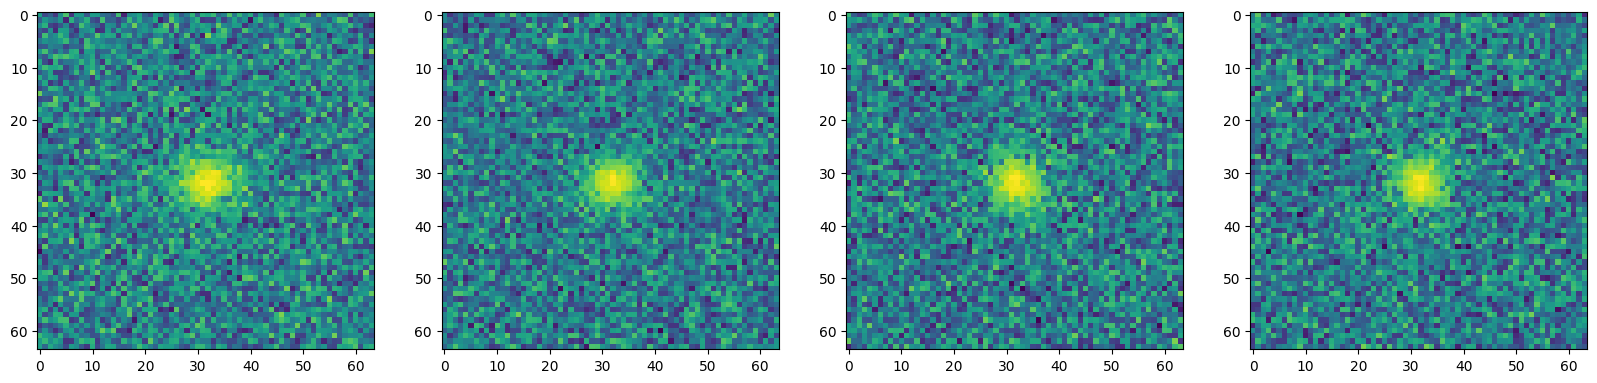

In [35]:
# split the scene into individual galaxies
ia_cosmos_quadrants = []
nn = 64
ncols = scene_nx // nn
for i in range(ncols):
    for j in range(ncols):
        quadrant = ia_cosmos_scenes[0][i*nn:(i+1)*nn, j*nn:(j+1)*nn]
        ia_cosmos_quadrants.append(quadrant)

print(len(ia_cosmos_quadrants)//4)
plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(ia_cosmos_quadrants[i], norm='asinh')

In [40]:
rcut = 32
pixel_scale = 0.2
ngrid = 64

seeing = 0.8
psf_obj = galsim.Moffat(beta=2.5, fwhm=seeing, trunc=seeing*4.0)
psf_array = (
    psf_obj.shift(0.5 * pixel_scale, 0.5 * pixel_scale)
    .drawImage(nx=ngrid, ny=ngrid, scale=pixel_scale)
    .array
)

fpfs_config_outer = anacal.fpfs.FpfsConfig(
    sigma_arcsec=0.52, # detection kernel
    sigma_arcsec2=1.0 # measurement kernel
)

fpfs_config_inner = anacal.fpfs.FpfsConfig(
    sigma_arcsec=0.52, # detection kernel
    sigma_arcsec2=0.45 # measurement kernel
)

nstamp = np.sqrt(gals_per_scene).astype(int)
if do_force_detect:
    indx = np.arange(ngrid // 2, ngrid * nstamp, ngrid)
    indy = np.arange(ngrid // 2, ngrid * nstamp, ngrid)
    ns = len(indx) * len(indy)
    inds = np.meshgrid(indy, indx, indexing="ij")
    yx = np.vstack([np.ravel(_) for _ in inds])
    buff = 0
    dtype = np.dtype(
        [
            ("y", np.int32),
            ("x", np.int32),
            ("is_peak", np.int32),
            ("mask_value", np.int32),
        ]
    )
    coords = np.empty(ns, dtype=dtype)
    coords["y"] = yx[0]
    coords["x"] = yx[1]
    coords["is_peak"] = np.ones(ns)
    coords["mask_value"] = np.zeros(ns)
else:
    coords = None

# Measurement
output_outer = []
output_inner = []

for scene in tqdm(ia_cosmos_scenes):
    output_outer.append(
        anacal.fpfs.process_image(
            fpfs_config=fpfs_config_outer,
            gal_array=scene,
            psf_array=psf_array,
            pixel_scale=pixel_scale,
            noise_variance=max(noise_variance, 0.23),
            noise_array=noise_array,
            coords=coords
        )
    )

    output_inner.append(
        anacal.fpfs.process_image(
            fpfs_config=fpfs_config_inner,
            gal_array=scene,
            psf_array=psf_array,
            pixel_scale=pixel_scale,
            noise_variance=max(noise_variance, 0.23),
            noise_array=noise_array,
            coords=coords
        )
    )

100%|██████████| 1/1 [00:42<00:00, 42.54s/it]


In [41]:
# Extract the measurements
ename = "e1_2"
egname = "e1_g1_2"
wgname = "w_g1"

print("Measurement with sigma_arcsec=%.2f:" % fpfs_config_outer.sigma_arcsec2)
e1_0 = output_outer[0]["w"] * output_outer[0][ename]
e1g1_0 = (
        output_outer[0][wgname] 
        * output_outer[0][ename] 
        + output_outer[0]["w"] 
        * output_outer[0][egname]
    )

g1_outer = np.sum(e1_0) / np.sum(e1g1_0)
print(g1_outer)

print("Measurement with sigma_arcsec=%.2f:" % fpfs_config_inner.sigma_arcsec2)
e1_1 = output_inner[0]["w"] * output_inner[0][ename]
e1g1_1 = (
        output_inner[0][wgname] 
        * output_inner[0][ename] 
        + output_inner[0]["w"] 
        * output_inner[0][egname]
    )

g1_inner = np.sum(e1_1) / np.sum(e1g1_1)
print(g1_inner)

a = g1_inner/g1_outer

print("a = ", a)

Measurement with sigma_arcsec=1.00:
0.00013560425271932357
Measurement with sigma_arcsec=0.45:
0.0004175631619147943
a =  3.079277777364955


In [8]:
test_component = 1

print("Testing for shear component: %d" % test_component)
print("Measurement with sigma_arcsec=%.2f:" % fpfs_config.sigma_arcsec)
ename = "e%d" % test_component
egname = "e%d_g%d" % (test_component, test_component)
wgname = "w_g%d" % test_component
e1_0 = out[0]["w"] * out[0][ename]
e1_1 = out[1]["w"] * out[1][ename]
e1g1_0 = out[0][wgname] * out[0][ename] + out[0]["w"] * out[0][egname]
e1g1_1 = out[1][wgname] * out[1][ename] + out[1]["w"] * out[1][egname]

# Measurement
g1_1 = np.sum(e1_0) / np.sum(e1g1_0)
print("g1: %.7f" % g1_1)

print("Measurement with sigma_arcsec=%.2f:" % fpfs_config.sigma_arcsec2)
ename = "e%d_2" % test_component
egname = "e%d_g%d_2" % (test_component, test_component)
e1_0 = out[0]["w"] * out[0][ename]
e1_1 = out[1]["w"] * out[1][ename]
e1g1_0 = out[0][wgname] * out[0][ename] + out[0]["w"] * out[0][egname]
e1g1_1 = out[1][wgname] * out[1][ename] + out[1]["w"] * out[1][egname]

g1_2 = np.sum(e1_0) / np.sum(e1g1_0)
print("g1: %.7f" % g1_2)

Testing for shear component: 1
Measurement with sigma_arcsec=1.00:
g1: 0.0013527
Measurement with sigma_arcsec=0.45:
g1: 0.0010407


In [9]:
print(g1_2/g1_1)

0.7693807249281339


### Unforced detection
Kernels: 1.0, 0.65
- w/ noise a = 0.78
- w/o noise a = 0.87

Kernels: 1.0, 0.45
- w/ noise a = 0.51
- w/o noise a = 0.76

### Forced detection
Kernels: 1.0, 0.65
- w/ noise a = 0.55
- w/o noise a = 0.86

Kernels: 1.0, 0.45
- w/ noise a = 0.81
- w/o noise a = 0.74

## Checking results of multiple noise realisations

In [1]:
import numpy as np
import matplotlib.pyplot as plt

0.6157833564986389 [ 21.21528263  13.36402342  12.40798231  14.17983258 214.43518574
   7.7554116    4.53041502  55.74549543]
[ 1024  2209  3969  6084  8836 11881 15625 19881]


Text(0.5, 0, 'n_samples')

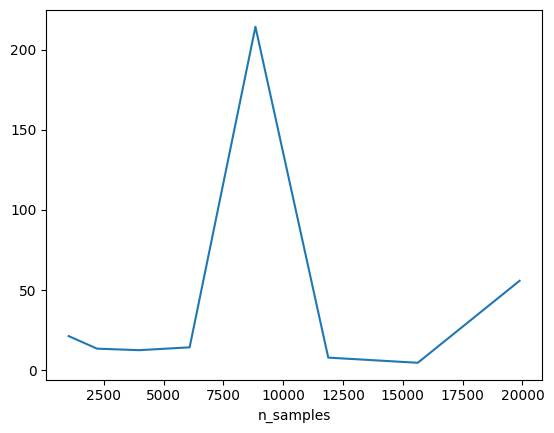

In [2]:
data = np.load('a_vals_niter=50_seed=42_year=1.npz')
a_vals = data['a_vals']
samples = data['samples']

# n_iter, n_samples
a_true = a_vals[0,0]
a_deviation = np.std(a_vals, axis=0)
print(a_true, a_deviation)
print(samples)
plt.plot(samples, a_deviation)
plt.xlabel('n_samples')

In [38]:
import numpy as np

def find_spaced_squares(start, end, N):
    # Take the square roots of start and end, rounding up and down
    sqrt_start = int(np.ceil(np.sqrt(start)))
    sqrt_end = int(np.floor(np.sqrt(end)))
    
    # Generate N linearly spaced values between the square roots (as integers)
    spaced_roots = np.linspace(sqrt_start, sqrt_end, N).astype(int)
    
    # Square those values to get perfect squares
    spaced_squares = np.square(spaced_roots)
    
    return spaced_squares

# Example usage:
start = 1000
end = 81499
N = 10
squares = find_spaced_squares(start, end, N)
print(squares)
print(np.sqrt(squares))

[ 1024  3600  7744 13456 20736 29584 40000 51984 65536 81225]
[ 32.  60.  88. 116. 144. 172. 200. 228. 256. 285.]
